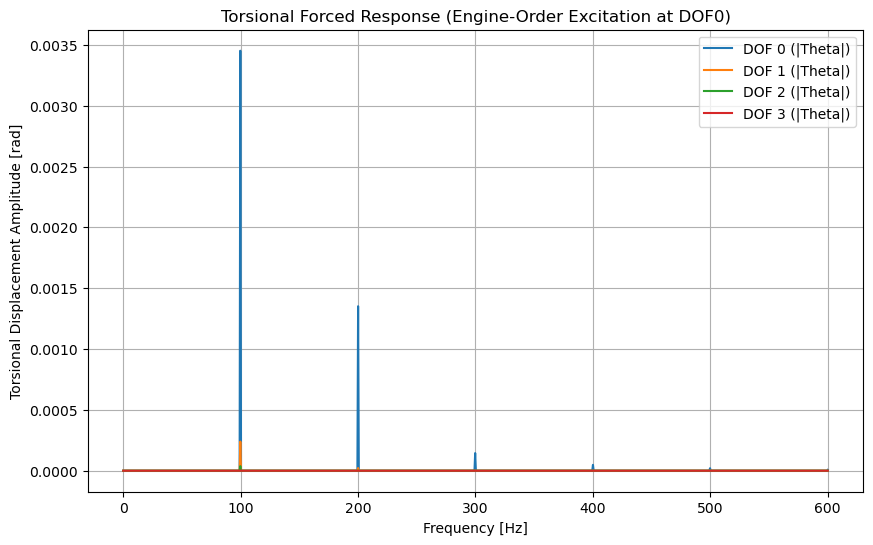


Undamped Natural Frequencies (Hz):
  Mode 1: nan Hz
  Mode 2: 21.926 Hz
  Mode 3: 44.343 Hz
  Mode 4: 55.174 Hz

Engine Orders and Assigned Frequency Index:
  Order 0.5 => f=100.00 Hz => amplitude=10.0 => index=166
  Order 1.0 => f=200.00 Hz => amplitude=20.0 => index=333
  Order 1.5 => f=300.00 Hz => amplitude=5.0 => index=499
  Order 2.0 => f=400.00 Hz => amplitude=3.0 => index=666
  Order 2.5 => f=500.00 Hz => amplitude=2.0 => index=832
  Order 3.0 => f=600.00 Hz => amplitude=1.0 => index=999
  Order 3.5 => f=700.00 Hz (outside sweep range)
  Order 4.0 => f=800.00 Hz (outside sweep range)
  Order 4.5 => f=900.00 Hz (outside sweep range)

Done.


C:\Users\mallwitzd\AppData\Local\Temp\ipykernel_17472\77309072.py:111: RuntimeWarning: invalid value encountered in sqrt
  omega_n = np.sqrt(eigvals)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh, eig

###############################################################################
# 1) Build torsional chain matrices
###############################################################################
def build_torsional_chain_matrices(J, c, k):
    """
    Build full NxN inertia (J), damping (C), and stiffness (K) matrices
    for a torsional chain system of N inertias.
    
    The arrays c[] and k[] are of length N:
      - c[0], k[0] => external damper/stiffness from DOF0 to ground
      - c[i], k[i] => connection between DOF i and DOF (i-1), for i=1..N-1
      - c[N-1], k[N-1] => external damper/stiffness from DOF(N-1) to ground
        (like a “boundary condition” for the last inertia)
        
    If you do NOT want the last inertia connected to ground, you can
    set c[-1] = 0 and k[-1] = 0. Be aware this might make the system
    singular in the frequency domain.
    """
    N = len(J)
    # Inertia matrix: diagonal
    J_full = np.diag(J)
    
    # Damping matrix
    C_full = np.zeros((N, N), dtype=float)
    # Stiffness matrix
    K_full = np.zeros((N, N), dtype=float)
    
    # DOF0: includes “ground” connection via c[0], k[0]
    C_full[0, 0] = c[0]
    K_full[0, 0] = k[0]
    
    # Then for i=1..N-1, the damping/stiffness c[i], k[i] connect
    # DOF i to ground if i==N-1, or DOF i to DOF i-1 otherwise.
    for i in range(1, N):
        # Add c[i], k[i] to diagonal
        C_full[i, i] += c[i]
        K_full[i, i] += k[i]
        
        # If i>0 and we interpret c[i],k[i] as between DOF i and i-1:
        C_full[i, i-1] = -c[i]
        C_full[i-1, i] = -c[i]
        K_full[i, i-1] = -k[i]
        K_full[i-1, i] = -k[i]
    
    return J_full, C_full, K_full

###############################################################################
# 2) Compute torsional poles (optional)
###############################################################################
def compute_torsional_poles(J, c, k):
    """
    For the torsional system J * theta'' + C * theta' + K * theta = 0,
    build the state-space form and compute eigenvalues (poles).
    """
    N = len(J)
    J_full, C_full, K_full = build_torsional_chain_matrices(J, c, k)
    Minv = np.linalg.inv(J_full)
    
    zero_block = np.zeros((N, N))
    I_block = np.eye(N)
    
    A_upper = np.hstack((zero_block, I_block))
    A_lower = np.hstack((-Minv @ K_full, -Minv @ C_full))
    A = np.vstack((A_upper, A_lower))
    
    poles, _ = eig(A)
    return poles

###############################################################################
# 3) Forced response (complex frequency response)
###############################################################################
def compute_torsional_forced_response(J, c, k, w, T_vec):
    """
    Solve [K + j*w*C - w^2 * J] * Theta = T_vec for Theta at frequency w,
    where T_vec is the complex torque vector (length N).
    """
    # Build the NxN "dynamic stiffness" = K + j*w*C - w^2 J
    J_full, C_full, K_full = build_torsional_chain_matrices(J, c, k)
    dyn_stiff = K_full + 1j*w*C_full - (w**2)*J_full
    
    # Solve for Theta
    Theta = np.linalg.solve(dyn_stiff, T_vec)
    return Theta

###############################################################################
# 4) Free (undamped) vibration analysis
###############################################################################
def free_vibration_analysis(J, k):
    """
    Undamped free-vibration analysis for a torsional chain:
      J * theta'' + K * theta = 0
    => Solve K_full * phi = (omega^2) * J_full * phi
    => eigenvalues => (omega^2), so omega = sqrt(eigval).
    
    Returns:
      f_n: natural frequencies in Hz
      eigvecs: matrix of eigenvectors (columns are mode shapes)
      J_full, K_full: the NxN system matrices
    """
    N = len(J)
    J_full, _, K_full = build_torsional_chain_matrices(J, np.zeros(N), k)
    
    # Solve generalized eigenvalue problem
    eigvals, eigvecs = eigh(K_full, J_full)  # real, symmetrical
    
    # rad/s
    omega_n = np.sqrt(eigvals)
    # convert to Hz
    f_n = omega_n / (2.0 * np.pi)
    return f_n, eigvecs, J_full, K_full

###############################################################################
# 5) Main script
###############################################################################
def main():
    """
    Example main:
      - Define a torsional chain system (J, c, k).
      - Define engine orders and amplitudes.
      - Build torque excitation for each frequency (superposition).
      - Solve forced response across a frequency sweep.
      - Plot results and do a quick free-vibration analysis.
    """
    # -------------------------------------------------------------------------
    # USER INPUTS
    # -------------------------------------------------------------------------
    # Example: 4 inertias
    # (units: J [kg*m^2], c [N*m*s/rad], k [N*m/rad])
    J = np.array([0.01, 0.02, 0.015, 0.01])
    c = np.array([0.1, 0.05, 0.1, 0.05])    # length=4 => c[0] is DOF0-to-ground, etc.
    k = np.array([1000.0, 500.0, 800.0, 200.0])
    
    # If you want the last inertia to be truly free, set c[-1] = 0, k[-1] = 0
    # but be aware: the system may be singular. For demonstration:
    # c[-1] = 0.0
    # k[-1] = 0.0
    
    # Frequency range to evaluate
    f_min = 0.1
    f_max = 600.0
    num_points = 1000
    
    # ENGINE-ORDER-BASED EXCITATION
    # Suppose the engine rotates at 12000 rpm => 200 rps fundamental
    engine_speed_rps = 12000.0 / 60.0  # rev/s = 200
    
    # Define engine orders (0.5 up to 5.0 in steps of 0.5)
    engine_orders = np.arange(0.5, 5.1, 0.5)
    
    # User-defined amplitude of each order (N.B. just an example)
    # These are torque amplitudes [N*m] for each order.
    order_amplitudes = np.array([10.0, 20.0, 5.0, 3.0, 2.0, 1.0, 1.0, 0.5, 0.1])
    # Make sure order_amplitudes has the same length as engine_orders
    
    # -------------------------------------------------------------------------
    # BUILD FREQUENCY ARRAY + SUPERPOSITION AMPLITUDES
    # -------------------------------------------------------------------------
    f_vals = np.linspace(f_min, f_max, num_points)
    w_vals = 2.0 * np.pi * f_vals
    
    # We'll create a torque_amplitudes array, one for each frequency in f_vals.
    torque_amplitudes = np.zeros(num_points, dtype=float)
    
    # For each engine order, we place the corresponding amplitude in the
    # nearest frequency bin. This is a discrete approach; in practice, you
    # might do interpolation or handle it differently if the order frequency
    # doesn't align exactly with an index in f_vals.
    for order_i, amp_i in zip(engine_orders, order_amplitudes):
        f_engine_order = order_i * engine_speed_rps  # [Hz]
        if f_engine_order >= f_min and f_engine_order <= f_max:
            idx = np.argmin(np.abs(f_vals - f_engine_order))
            torque_amplitudes[idx] += amp_i  # superposition
    
    # -------------------------------------------------------------------------
    # COMPUTE FORCED RESPONSE
    # -------------------------------------------------------------------------
    N = len(J)
    # Prepare array to store solutions: Theta_vals[dof_index, freq_index]
    Theta_vals = np.zeros((N, num_points), dtype=complex)
    
    for i, w in enumerate(w_vals):
        # We'll apply torque only on the first DOF (DOF=0),
        # i.e. T_vec = [T(omega), 0, 0, ... ]^T
        T_vec = np.zeros(N, dtype=complex)
        T_vec[0] = torque_amplitudes[i]  # real amplitude
        
        # Solve forced response
        Theta = compute_torsional_forced_response(J, c, k, w, T_vec)
        Theta_vals[:, i] = Theta
    
    # For plotting, let's look at the amplitude of each DOF
    Theta_mag = np.abs(Theta_vals)
    
    # -------------------------------------------------------------------------
    # PLOT RESULTS
    # -------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    for dof_idx in range(N):
        plt.plot(f_vals, Theta_mag[dof_idx, :], label=f"DOF {dof_idx} (|Theta|)")
    plt.title("Torsional Forced Response (Engine-Order Excitation at DOF0)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Torsional Displacement Amplitude [rad]")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # -------------------------------------------------------------------------
    # OPTIONAL: Free-Vibration Analysis
    # -------------------------------------------------------------------------
    f_n, eigvecs, J_full, K_full = free_vibration_analysis(J, k)
    print("\nUndamped Natural Frequencies (Hz):")
    for i, fn in enumerate(f_n):
        print(f"  Mode {i+1}: {fn:.3f} Hz")
    # You can also look at mode shapes in eigvecs if desired.

    # -------------------------------------------------------------------------
    # OPTIONAL: Print where engine orders landed in your f_vals
    # -------------------------------------------------------------------------
    print("\nEngine Orders and Assigned Frequency Index:")
    for order_i, amp_i in zip(engine_orders, order_amplitudes):
        f_engine_order = order_i * engine_speed_rps
        if f_engine_order >= f_min and f_engine_order <= f_max:
            idx = np.argmin(np.abs(f_vals - f_engine_order))
            print(f"  Order {order_i} => f={f_engine_order:.2f} Hz => amplitude={amp_i} => index={idx}")
        else:
            print(f"  Order {order_i} => f={f_engine_order:.2f} Hz (outside sweep range)")
    
    print("\nDone.")


if __name__ == "__main__":
    main()
